In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import IPython
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
df = pd.read_csv("../input/annp2dataset/Training.csv")
# df = pd.read_csv("datasets/Training.csv")
print(df.shape)
df.head()
#ho 68528 istanti temporali e 7 features

(68528, 7)


Sponginess  Wonder level  Crunchiness  Loudness on impact  Meme creativity  \
0     7.97698       4.33494     10.67282             1.76692          3.22440   
1     8.07824       4.44616     10.56160             1.70716          3.32566   
2     8.02844       4.22372     10.56160             1.64906          3.17460   
3     8.02844       4.22372     10.56160             1.70716          3.17460   
4     7.87572       4.44616     10.45038             1.70716          3.27586   

   Soap slipperiness  Hype root  
0          51.681460    3.65434  
1          51.563598    3.47672  
2          50.863080    3.47672  
3          45.841581    3.47672  
4          47.126421    3.47672

In [4]:
scaler = MinMaxScaler()
ndf = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [5]:
def build_sequences(df, target_labels, window, stride, telescope):
  #the telescope tells us how many parameters i want to predict in the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    #target_labels allows to choose how many sensors we are going to predict in the future
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [6]:
# training dataset parameters
window=350 # size of the set of samples we're using to train the NN
stride=10 # space between the beginning of one window and the next
telescope=1200 # How many steps to predict in the future
target_labels = ndf.columns

In [7]:
FOLDS = 7

tscv = TimeSeriesSplit(n_splits=FOLDS)

X_train = []
y_train = []
X_test = []
y_test = []


for train_index, test_index in tscv.split(ndf.to_numpy()):
    X_train_temp_raw, X_test_temp_raw = ndf.iloc[train_index], ndf.iloc[test_index]
    X_train_temp, y_train_temp = build_sequences(X_train_temp_raw, target_labels, window, stride, telescope)
    X_test_temp, y_test_temp = build_sequences(X_test_temp_raw, target_labels, window, stride, telescope)
    X_train.append(X_train_temp)
    y_train.append(y_train_temp)
    X_test.append(X_test_temp)
    y_test.append(y_test_temp)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# for i in range(0, len(X_train)):
#     print(X_train[i].shape, y_train[i].shape)

# Training: one step prediction

In [8]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        axs[i].legend()
    plt.show()

In [9]:
# for i in range(0, len(X_train)):
#     inspect_multivariate(X_train[i], y_train[i], target_labels, telescope)

# Models

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Reshape

In [11]:
models = {}
results = {}

### One-shot Models

In [12]:
units_ratio = 256
input_shape = X_train[0].shape[1:]
output_shape = y_train[0].shape[1:]

models['350x1gru(256)'] = Sequential([
    GRU(units_ratio, input_shape=input_shape, return_sequences=False, name="gru_1"),
    Dense(1200*7, activation='relu', name="dense"),
    Reshape((1200,7), name="reshape_to_batch"),
])


2022-01-05 18:39:10.523556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 18:39:10.621410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 18:39:10.622358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 18:39:10.623615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
for model in models.values():
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    model.summary()
    print('***\n\n')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               203520    
_________________________________________________________________
dense (Dense)                (None, 8400)              2158800   
_________________________________________________________________
reshape_to_batch (Reshape)   (None, 1200, 7)           0         
Total params: 2,362,320
Trainable params: 2,362,320
Non-trainable params: 0
_________________________________________________________________
***




In [14]:
# model training parameters
batch_size = 32
epochs = 100

In [15]:
for key, model in models.items():
    fold_results = []
    for fold_idx in range(0, FOLDS):
        res = model.fit(
            x = X_train[fold_idx],
            y = y_train[fold_idx],
            batch_size = batch_size,
            epochs = epochs,
            validation_split=0.1,
            callbacks = [
#                tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=5, restore_best_weights=True),
#                tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)
            ]
        ).history
        
        fold_results.append(res)
        model.save(f'models/{key}/{fold_idx}')
        IPython.display.clear_output()
    results[key] = fold_results

In [16]:
# for key, model in models.items():
#     model.save(f'models/{key}')

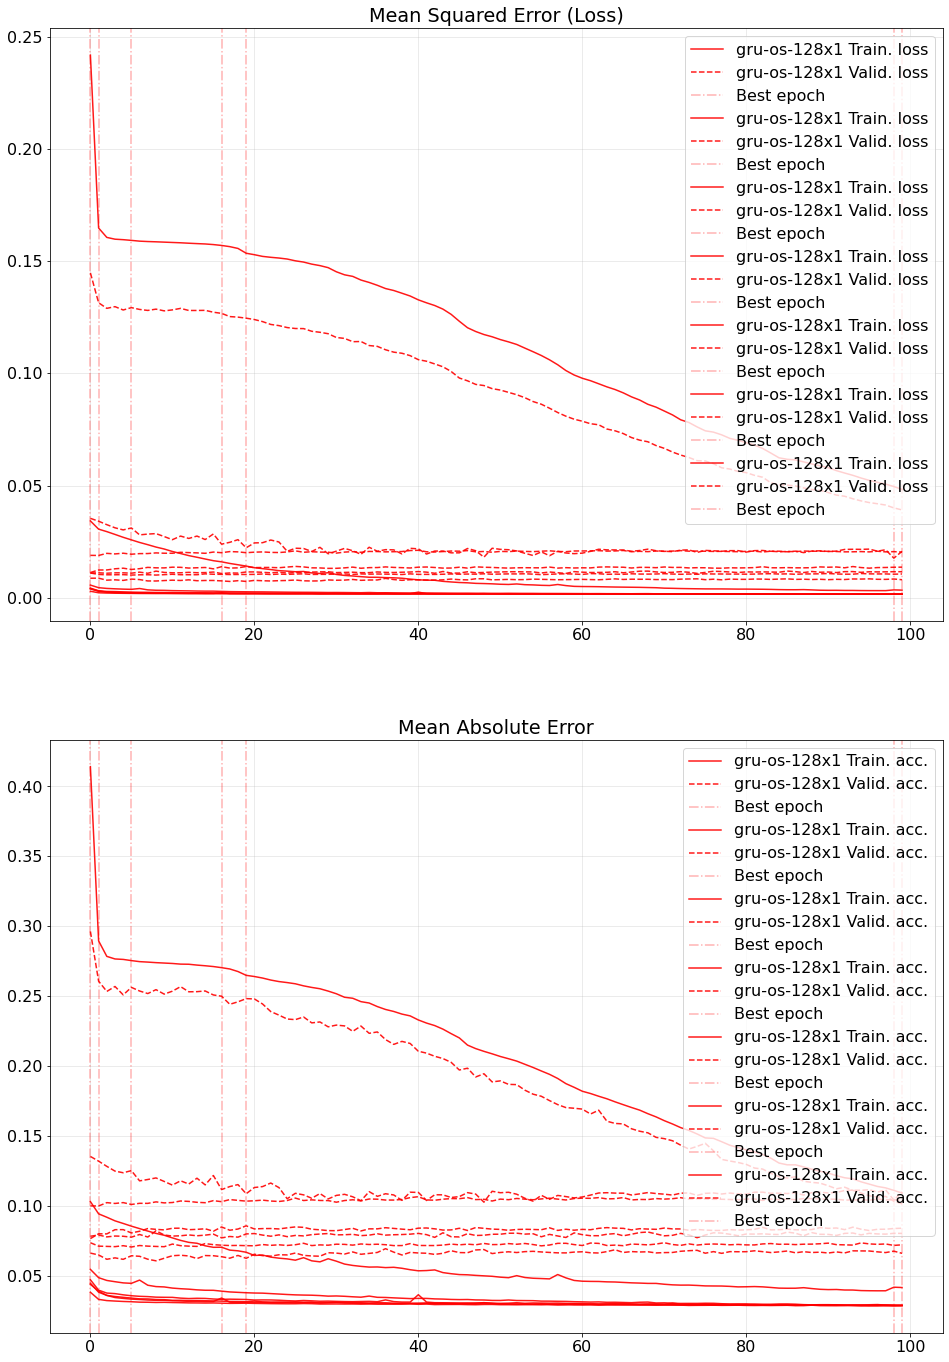

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(16, 24))

colors = ['red', 'green', 'blue', 'orange']

for index, (key, histories) in enumerate(results.items()):
    for history in histories:
        best_epoch = np.argmin(history['val_loss'])

        ax[0].plot(history['loss'], label=f'{key} Train. loss', alpha=.9, color=colors[index])
        ax[0].plot(history['val_loss'], label=f'{key} Valid. loss', alpha=.9, color=colors[index], ls='--')
        ax[0].axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='-.', color=colors[index])
        #ax[0].axis([0, 80, 0, 0.02])
        ax[0].set_title('Mean Squared Error (Loss)')
        ax[0].legend()
        ax[0].grid(alpha=.3)

        ax[1].plot(history['mae'], label=f'{key} Train. acc.', alpha=.9, color=colors[index])
        ax[1].plot(history['val_mae'], label=f'{key} Valid. acc.', alpha=.9, color=colors[index], ls='--')
        ax[1].axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='-.', color=colors[index])
        #ax[1].axis([0, 80, 0, 0.10])
        ax[1].set_title('Mean Absolute Error')
        ax[1].legend()
        ax[1].grid(alpha=.3)

#         ax[2].plot(history['lr'], label='Second model Learning Rate', alpha=.8, color=colors[index])
#         ax[2].axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='-.', color=colors[index])
#         ax[2].legend()
#         ax[2].grid(alpha=.3)

## Testing

In [19]:
predictions = {}

In [20]:
for key, model in models.items():
    for fold_idx in range(0, FOLDS):
        X_test_tmp = X_test[fold_idx]
        y_test_tmp = y_test[fold_idx]
        print(X_test_tmp.shape, y_test_tmp.shape)
        model = load_model(f'models/{key}/{fold_idx}')
        pred = model.predict(X_test_tmp)
        print(f'{key}/{fold_idx} : {pred.shape}')
        predictions[f'{key}/{fold_idx}'] = pred

(720, 350, 7) (720, 1200, 7)
gru-os-128x1/0 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/1 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/2 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/3 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/4 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/5 : (720, 1200, 7)
(720, 350, 7) (720, 1200, 7)
gru-os-128x1/6 : (720, 1200, 7)


In [21]:
# for key, model in models.items():
#     input = model.layers[0].input.shape
#     output = model.layers[-1].output.shape
#     print(f'{key} \t{input}')
#     print(f'\t\t{output}')

#     X_test_temp, y_test_temp = build_sequences(X_test_raw, target_labels, input[1], stride, output[1])
#     print(X_test_raw.shape, X_test_temp.shape, y_test_temp.shape)
#     pred = model.predict(X_test_temp)
#     print(f'{key} : {pred.shape}')
#     predictions[key] = pred

In [22]:
## DOWNLOAD MODEL
import shutil
from datetime import date
link = shutil.make_archive(f"MODELS-{date.today()}", "zip", "./models/")

In [23]:
models.keys()

dict_keys(['gru-os-128x1'])

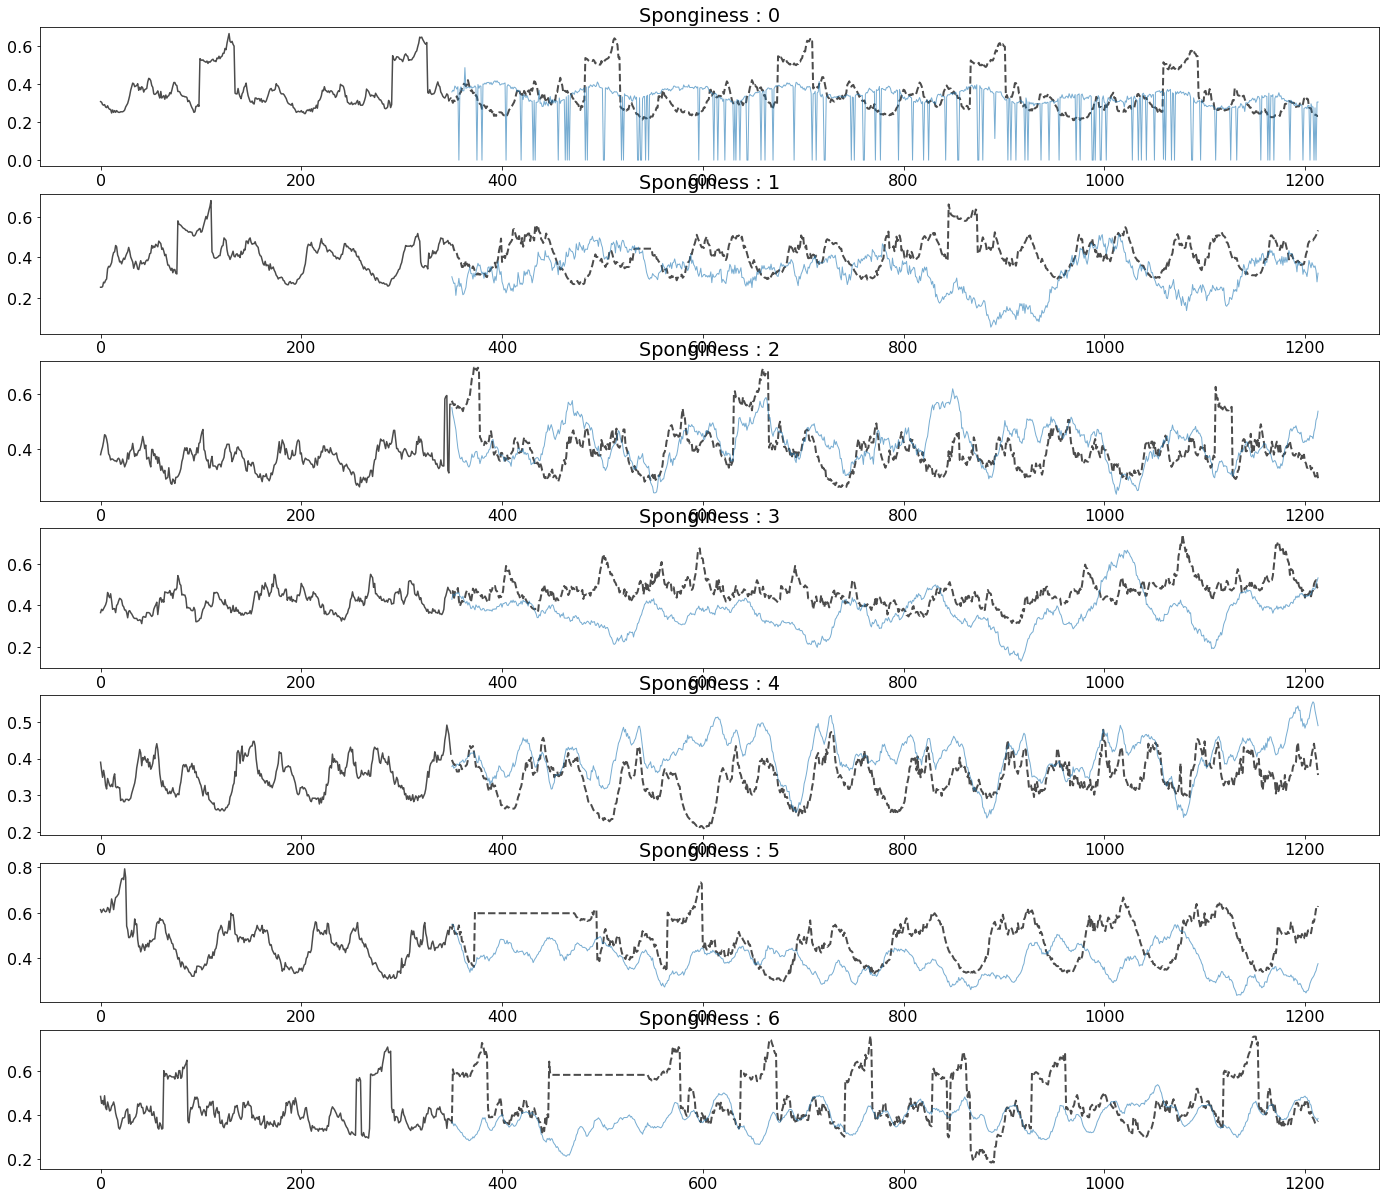

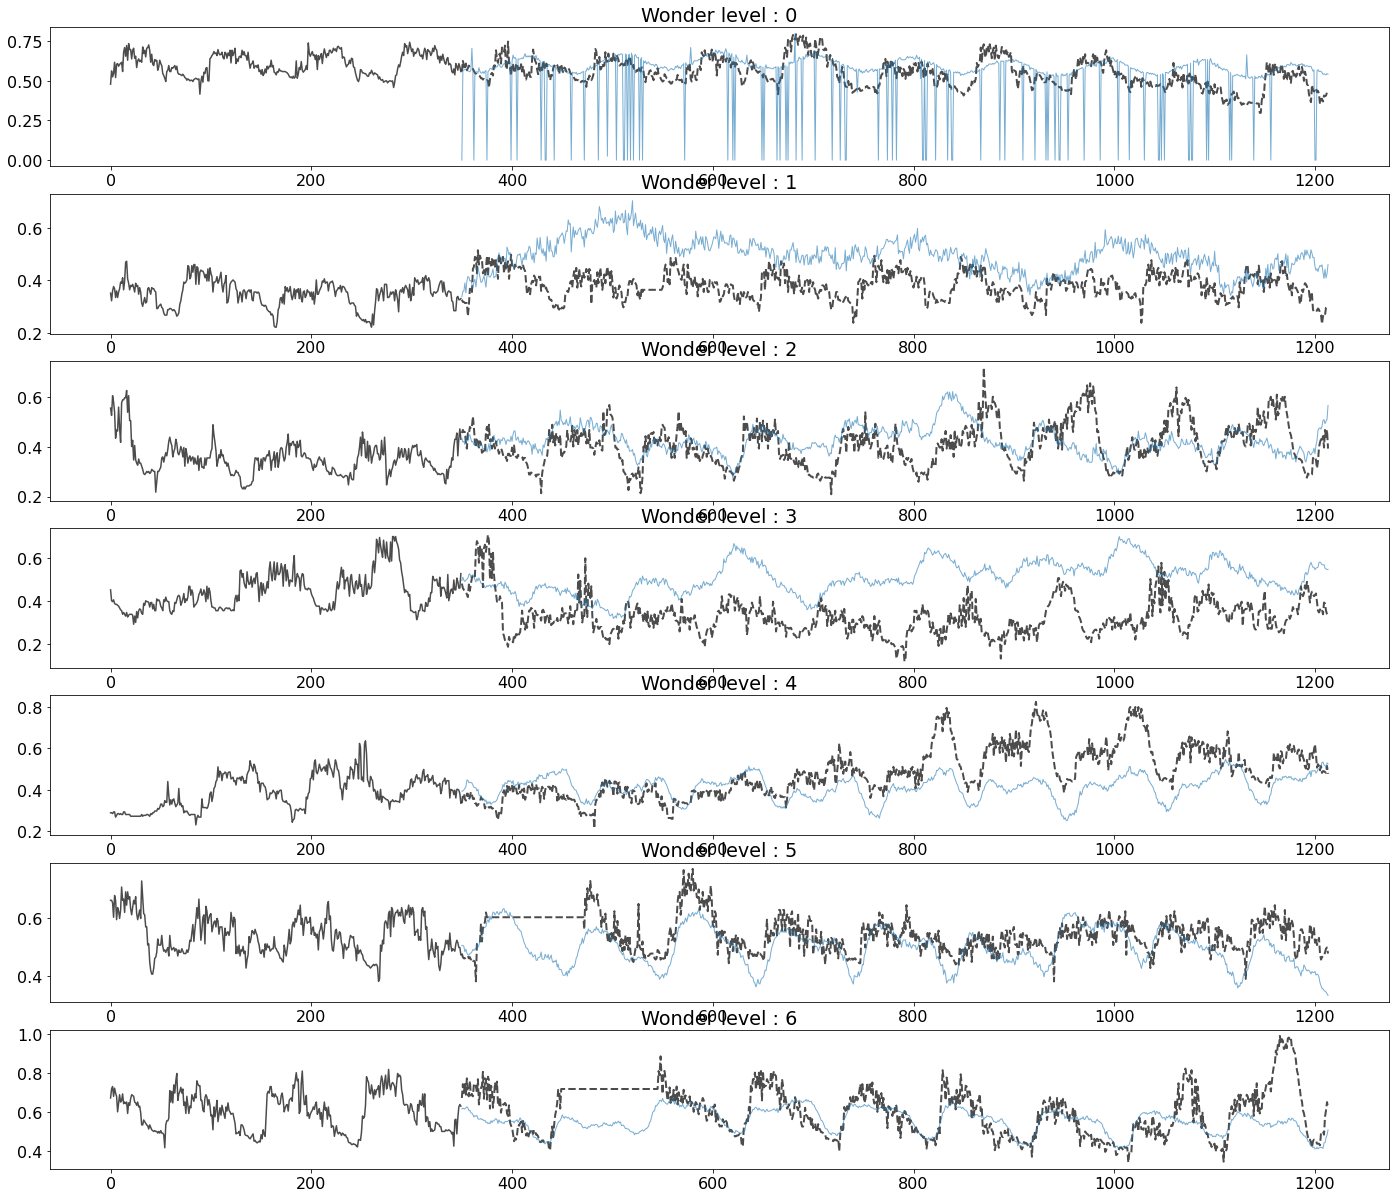

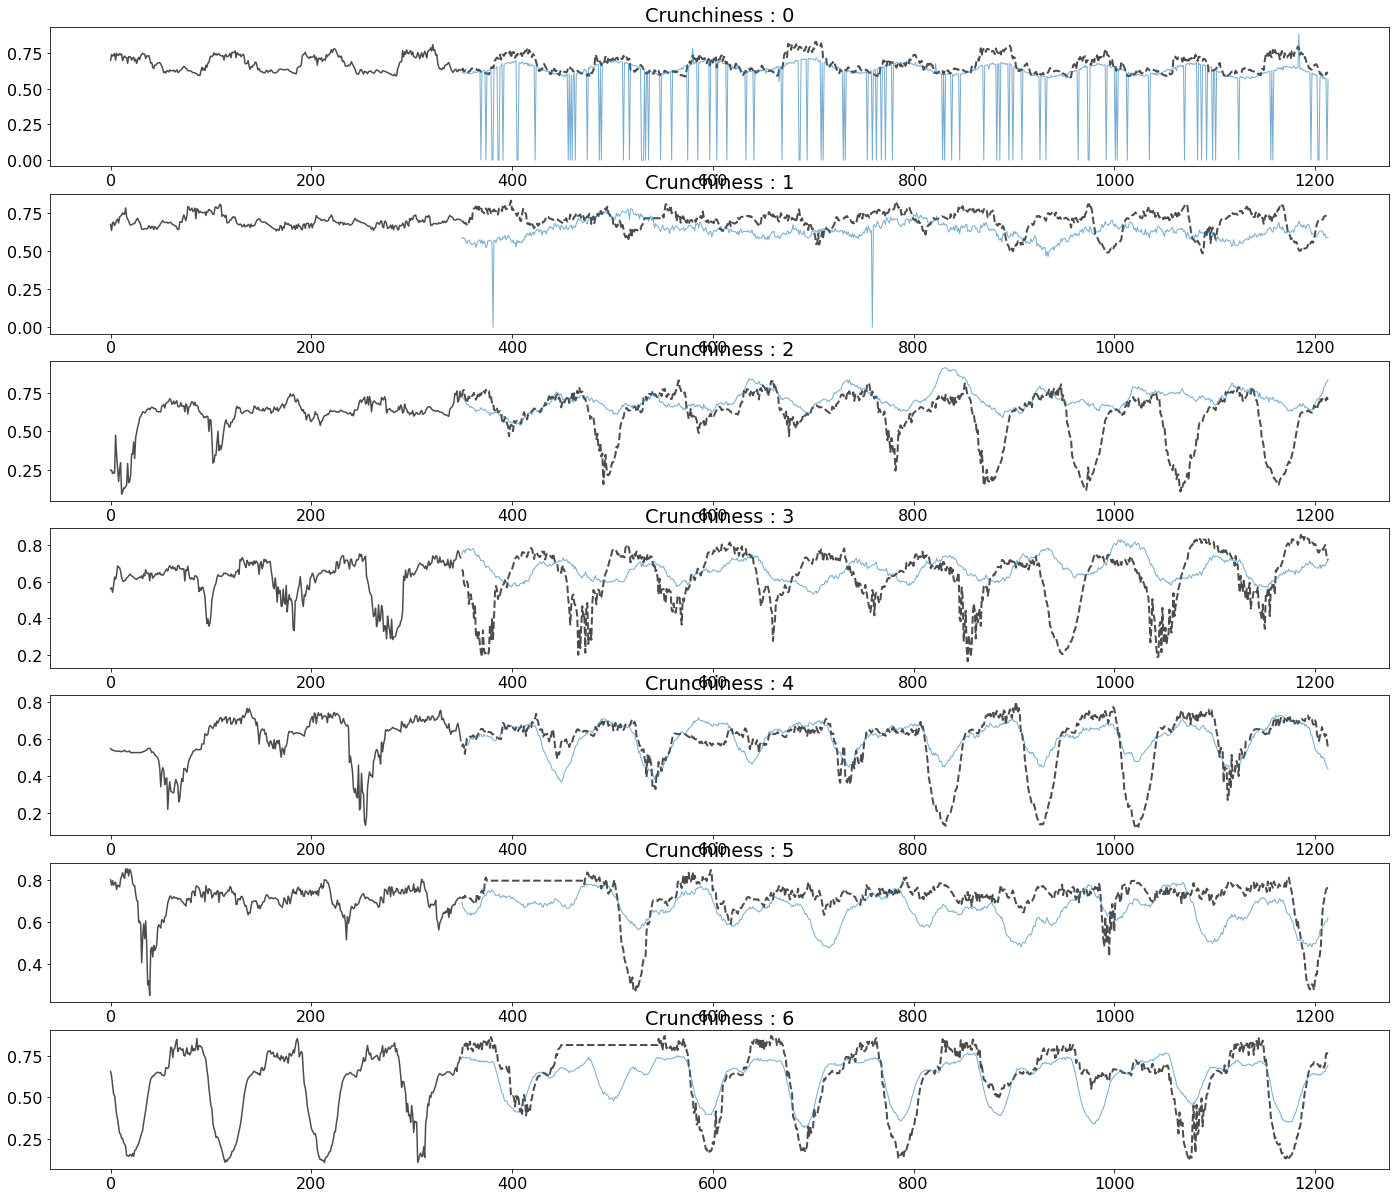

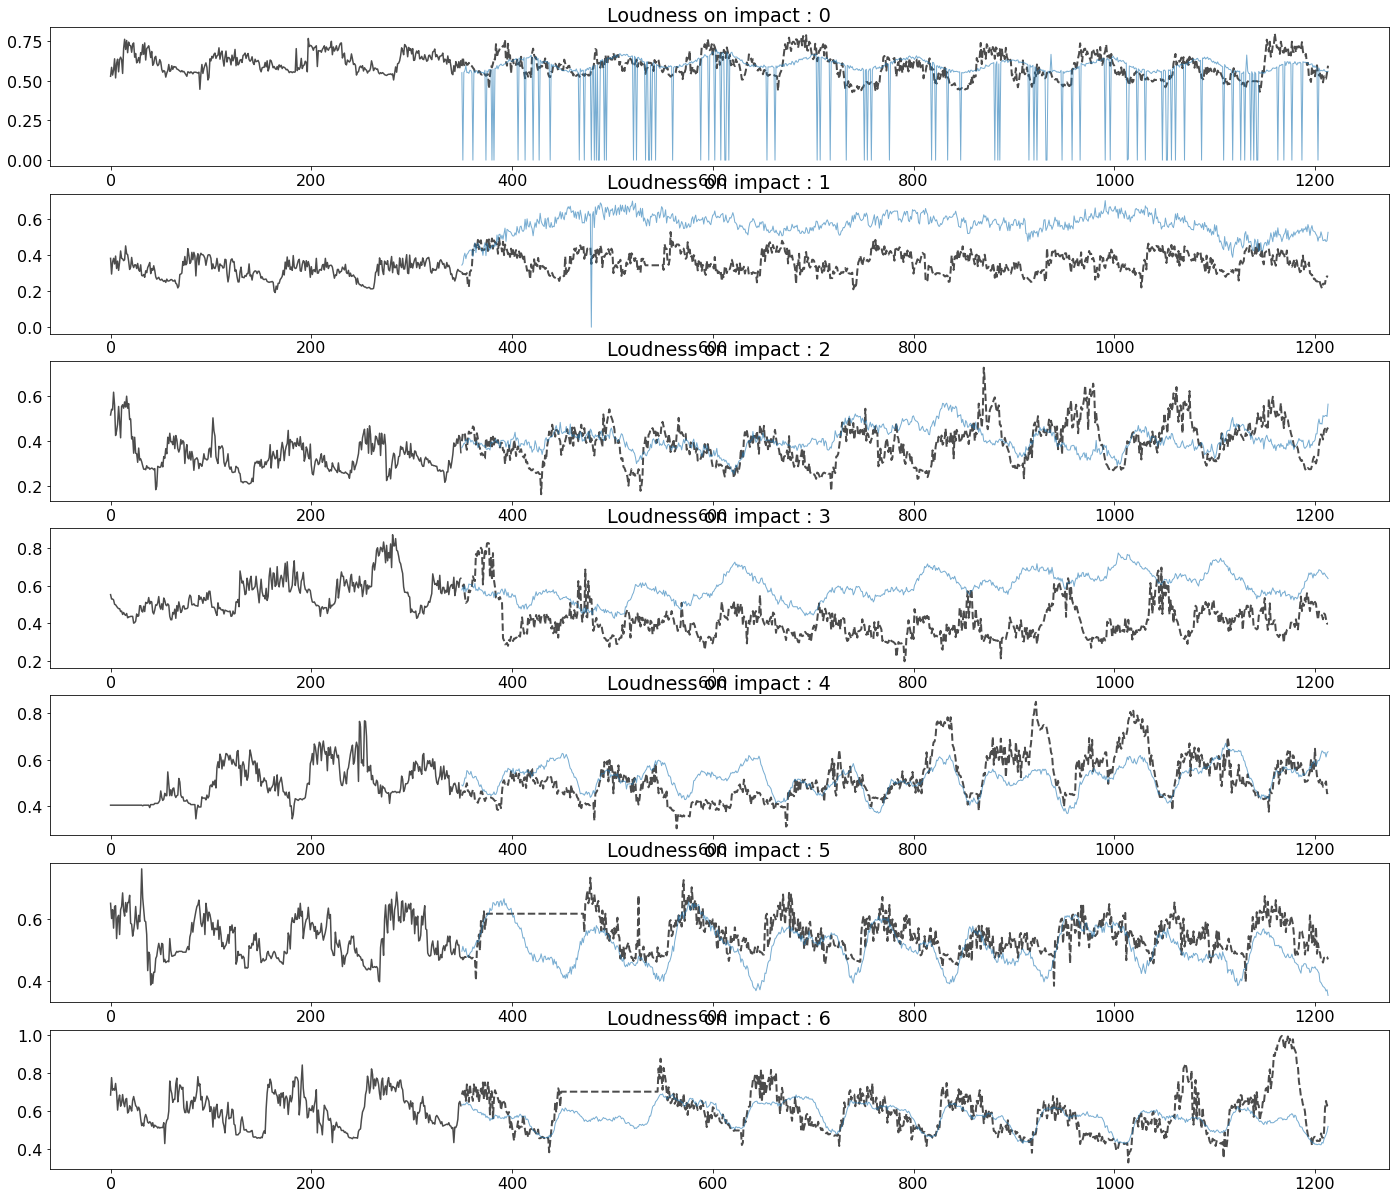

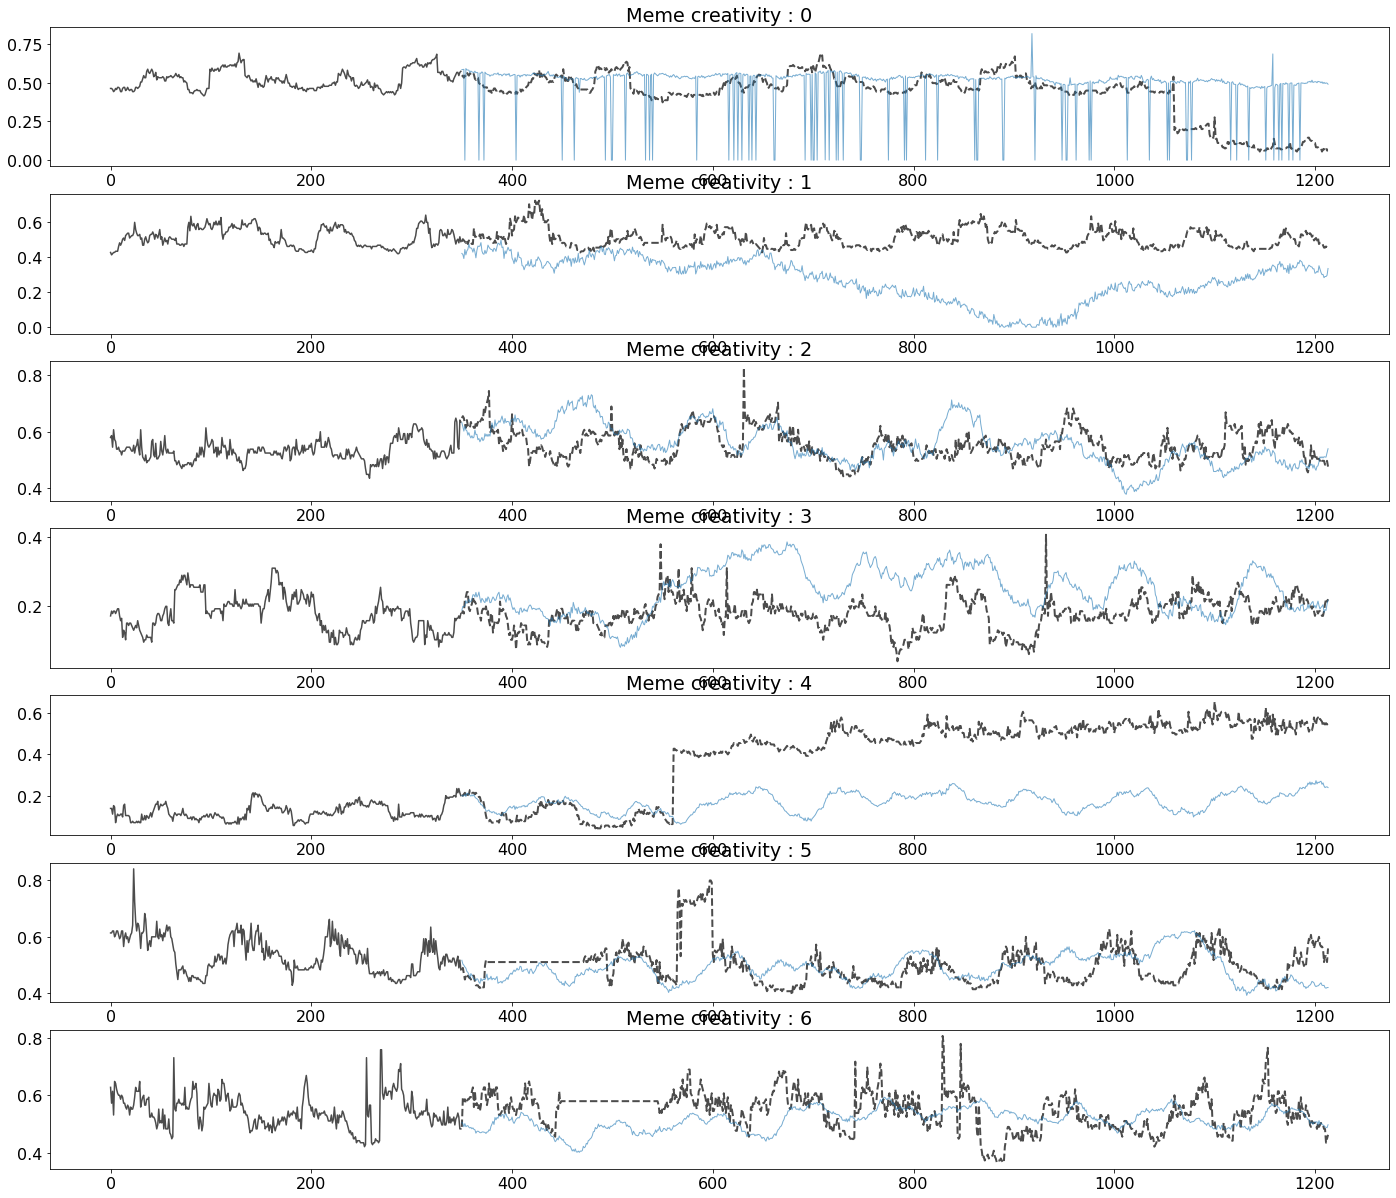

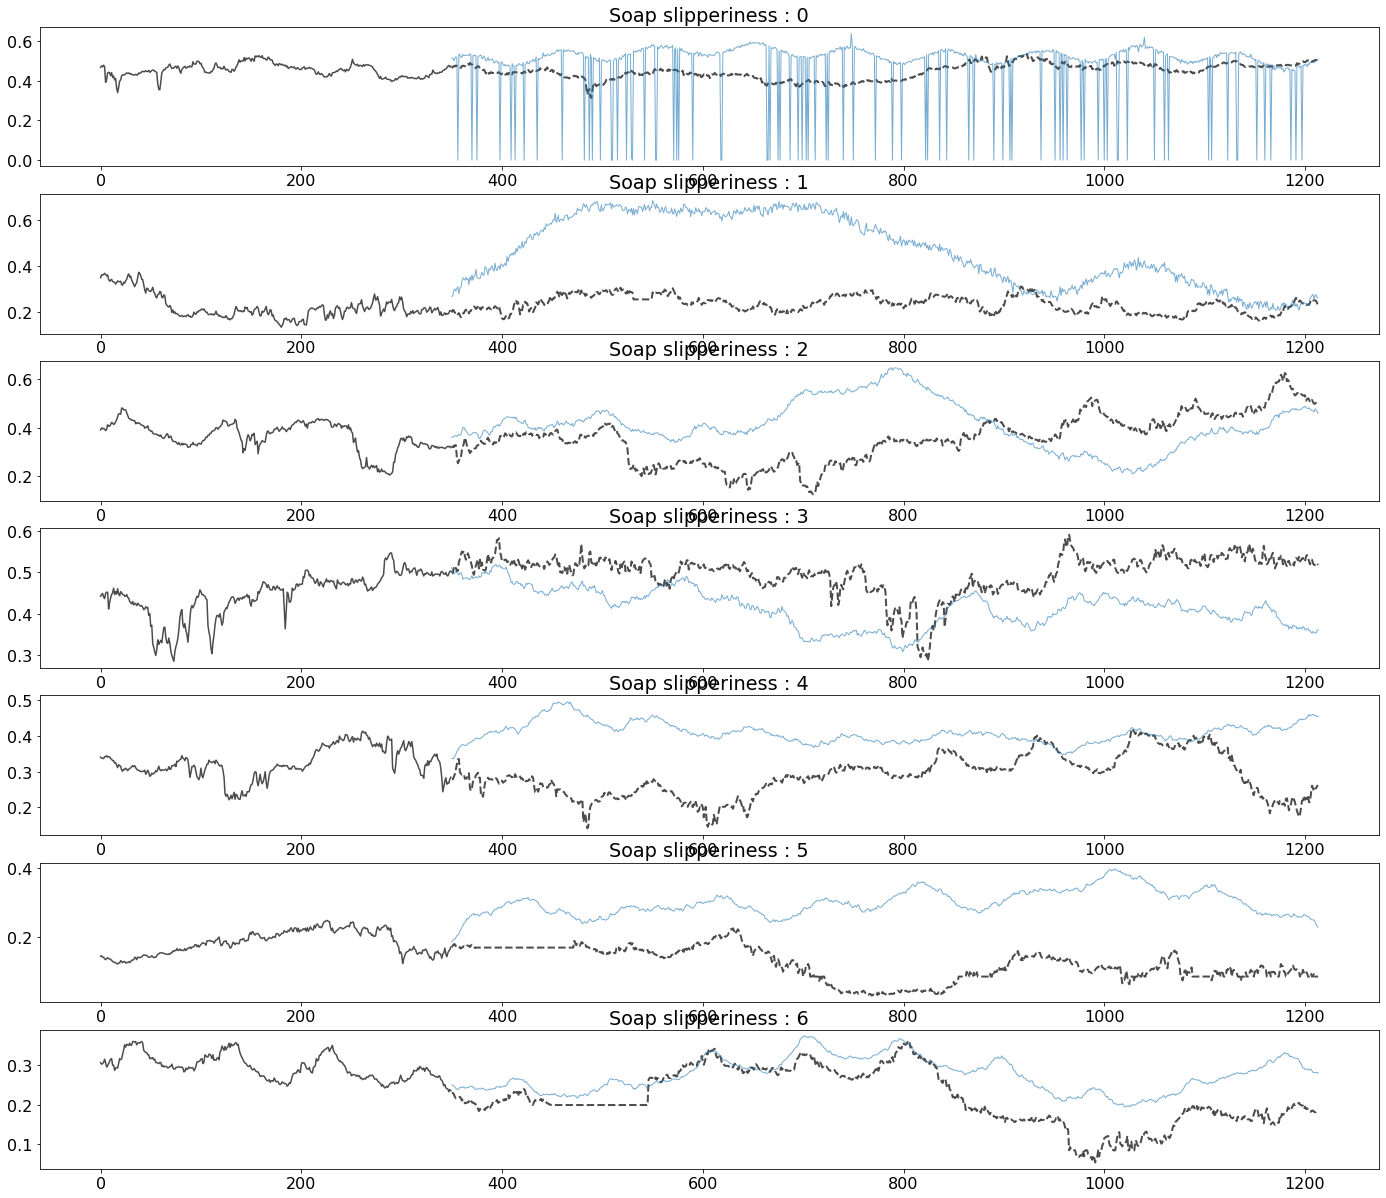

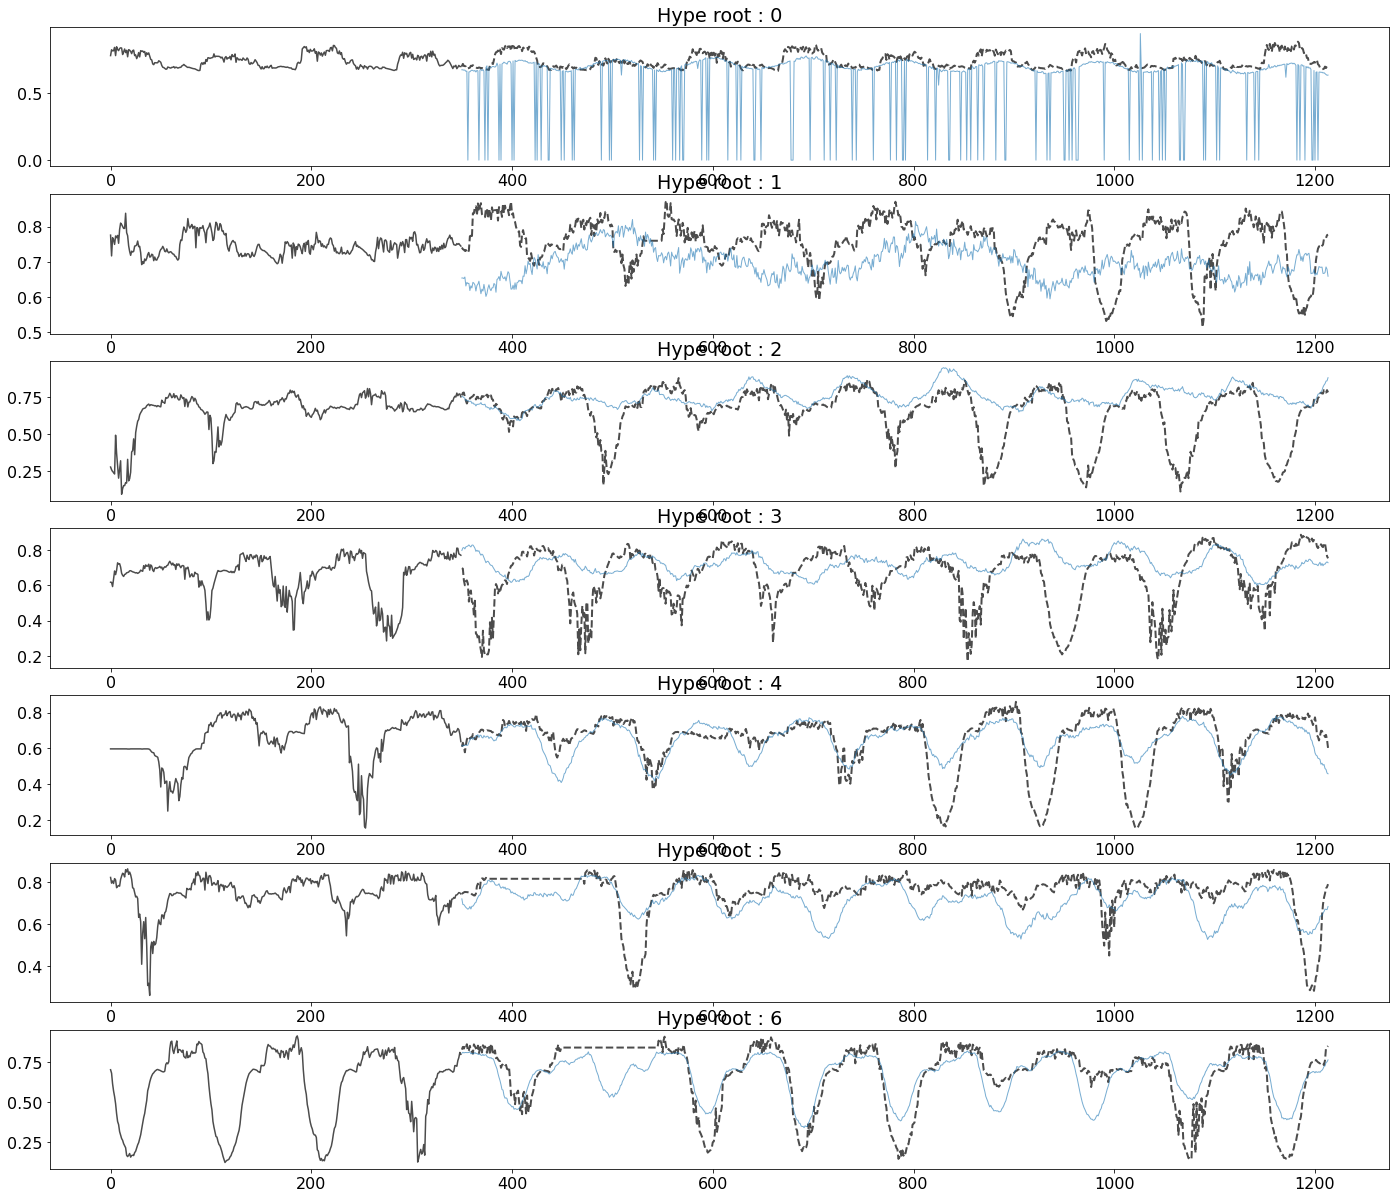

In [24]:
def inspect_kfold_predictions(Xs, ys, preds, columns, telescope, idx=None, xlim=None):
        
    # Get the min index from values shapes (in case there are different sized batches of predictions)
    if(idx==None):
        idx=np.random.randint(0, min(list(map(lambda x: x.shape[0], preds.values()))))
        
    for i, col in enumerate(columns):        
        feat_fig, feat_axs = plt.subplots(FOLDS, 1, sharex=False, figsize=(24, 3 * FOLDS))
        for fold_idx in range(0, FOLDS):
            X = Xs[fold_idx]
            y = ys[fold_idx]
            feat_axs[fold_idx].set_title(f'{col} : {fold_idx}')
            feat_axs[fold_idx].plot(np.arange(len(X[0,:,i])), X[idx,:,i], color='black', alpha=0.7)
            feat_axs[fold_idx].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:telescope,i], color='black', alpha=0.7, ls='--', lw=2, label='Real')
            for key in models.keys():
                pred = preds[f'{key}/{fold_idx}']
                feat_axs[fold_idx].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:telescope,i], lw=1, alpha=0.6, label=f'Pred. {key}')
                
inspect_kfold_predictions(X_test, y_test, predictions, target_labels[:], 864)